IMAGE CLASSIFICATION USING AWS SAGEMAKER AND S3 

In [2]:
# importing python librabries and framework
import sys
from pathlib import Path
import numpy as np
import cv2
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from glob import glob
import shutil
import torch, torchvision
from torch import nn, optim
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import sagemaker

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

COLORS_PALETTE=["#01BEFE","#FFDD00","#FF7D00","#FF006D","#ADFF02","#8F00FF"]

sns.set_palette(sns.color_palette(COLORS_PALETTE))

rcParams['figure.figsize'] = 15, 10

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

Creating sagemaker session and specifying the path

In [3]:
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
prefix = "sagemaker/pytorch-vt-resnet34"
role = sagemaker.get_execution_role()

**PREPROCESSING**

The dataset used is Intel Image Classification downloaded from kaggle.com. It contains around 25k images of size 150x150 distributed under 6 categories.

extracting files from the zip file which consists of the dataset to a folder named imageclassification

In [4]:
from zipfile import ZipFile
with ZipFile('imageclassification.zip', 'r') as zipObj:
   zipObj.extractall('imageclassification')

Giving the stored path to train, test and prediction.

In [5]:
# Store location for train, test and prediction dataset. 
train_set = './imageclassification/intel-image-classification/seg_train/seg_train'
test_set = './imageclassification/intel-image-classification/seg_test/seg_test'
pred_set = './imageclassification/intel-image-classification/seg_pred/seg_pred'

Assigning the index to all the six classifications in our dataset
{'buildings' -> 0,
'forest' -> 1,
'glacier' -> 2,
'mountain' -> 3,
'sea' -> 4,
'street' -> 5 }

In [6]:
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
class_indices = [0,1,2,3,4,5]

Displaying the count of folders for each classification

In [7]:
train_folders = sorted(glob(train_set + '/*'))
len(train_folders)

6

load_image() Function for loading images and show_image() for viewing images
show_sign_grid() for showing the images as a grid

In [8]:
def load_image(img_path, resize=True):
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    
    if resize:
        img = cv2.resize(img, (64,64), interpolation = cv2.INTER_AREA)
    
    return img

def show_image(img_path):
    img = load_image(img_path)
    plt.imshow(img)
    plt.axis('off')
    
def show_sign_grid(image_paths):
    images = [load_image(img) for img in image_paths]
    images = torch.as_tensor(images)
    images = images.permute(0,3,1,2)
    grid_img = torchvision.utils.make_grid(images, nrow=11)
    plt.figure(figsize=(24,12))
    plt.imshow(grid_img.permute(1,2,0))
    plt.axis('off')


Displaying random images from each classification in a image grid.

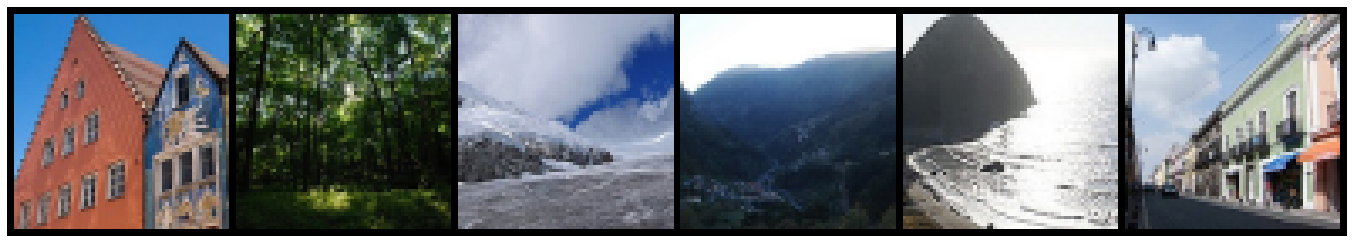

In [9]:
sample_images = [np.random.choice(glob(f'{tf}/*jpg')) for tf in train_folders]
show_sign_grid(sample_images)

Here we are copying images to new directory to re-organize the structure of the folder, the purpose is to make it easier for torchvision dataset helpers to utilize the images. 
We are going to reserve 80% for train and 20% for validation for each class, then copy them to the data folder.

In [10]:
!rm -rf data

DATA_DIR = Path('data')

DATASETS = ['train', 'val']

for ds in DATASETS:
    for cls in class_names:
        (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

Here we are counting the images in each classification.

In [11]:
for i, cls_index in enumerate(class_indices):
    image_paths = np.array(glob(f'{train_folders[cls_index]}/*jpg'))
    class_name = class_names[i]
    print(f'{class_name}: {len(image_paths)}')
    np.random.shuffle(image_paths)
    
    ds_split = np.split(
        image_paths,
        indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))]
    )
    
    dataset_data = zip(DATASETS, ds_split)
    for ds, images in dataset_data:
        for img_path in images:
            shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

buildings: 100
forest: 103
glacier: 100
mountain: 100
sea: 100
street: 100


We add some transformations to artifically increase the size of dataset, particularily random resizing, rotation and horizontal flips, then we normalize the tensors using present values for each channel.

In [12]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'train': T.Compose([
    T.RandomResizedCrop(size=224),
    T.RandomRotation(degrees=15),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean_nums, std_nums)
]), 'val': T.Compose([
    T.Resize(size=224),
    T.CenterCrop(size=224),
    T.ToTensor(),
    T.Normalize(mean_nums, std_nums)
]),}

Here creating the Pytorch Dataloader from the data directory.

In [13]:
image_datasets = {
    d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
    d: DataLoader(image_datasets[d], batch_size=16, shuffle=True, num_workers=4) for d in DATASETS
}

counting the images in datasets created above.

In [14]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes
dataset_sizes

{'train': 482, 'val': 60}

Showing the images in datasets created above.

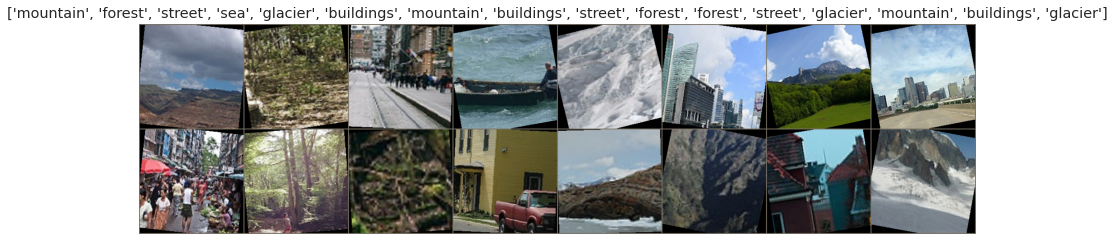

In [15]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([mean_nums])
    std = np.array([std_nums])
    inp = std * inp + mean
    inp = np.clip(inp,0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    
inputs, classes = next(iter(data_loaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Here We are going to use the sagemaker.Session.upload_data function to upload our datasets to an S3 location. The return value input_path identifies the S3 path and this path we are going to used for training the model.

In [16]:
%%time
%%timeit
# upload data to S3, this might take few minutes.
input_path = sagemaker_session.upload_data(path='data', bucket=bucket, key_prefix=prefix)
print('input specification (in this case, just an S3 path): {}'.format(input_path))
input_path = input_path

input specification (in this case, just an S3 path): s3://sagemaker-us-east-2-076505575643/sagemaker/pytorch-vt-resnet34
input specification (in this case, just an S3 path): s3://sagemaker-us-east-2-076505575643/sagemaker/pytorch-vt-resnet34
input specification (in this case, just an S3 path): s3://sagemaker-us-east-2-076505575643/sagemaker/pytorch-vt-resnet34
input specification (in this case, just an S3 path): s3://sagemaker-us-east-2-076505575643/sagemaker/pytorch-vt-resnet34
input specification (in this case, just an S3 path): s3://sagemaker-us-east-2-076505575643/sagemaker/pytorch-vt-resnet34
input specification (in this case, just an S3 path): s3://sagemaker-us-east-2-076505575643/sagemaker/pytorch-vt-resnet34
input specification (in this case, just an S3 path): s3://sagemaker-us-east-2-076505575643/sagemaker/pytorch-vt-resnet34
input specification (in this case, just an S3 path): s3://sagemaker-us-east-2-076505575643/sagemaker/pytorch-vt-resnet34
27.6 s ± 551 ms per loop (mean ±

In [19]:
input_path='s3://sagemaker-us-east-2-076505575643/sagemaker/pytorch-vt-resnet34'

Build and Train the model
For building a model we are use pretrained resnet34 model and replace the last layer with the custom visual transformer, to classify the images.
Steps in building the model
    Create a Visual Transformer class.
    Import ResNet34 pretrained model.
    Convert it into training mode.
    Train the model on new data.
    Evaluate model performance on validation loss , validation accuracy and execution time.
All the above steps are performed in Training script.

Training script
The model.py script provides all the code we need for training and hosting a SageMaker model. 

A typical training script loads data from the input channels, configures training with hyperparameters, trains a model, and saves a model to model_dir so that it can be hosted later. Hyperparameters are passed to your script as arguments and can be retrieved with an argparse.ArgumentParser instance.

In [45]:
%%time
%%timeit
!pygmentize code/model.py

import argparse
import json
import logging
import os
from pathlib import Path
import sys
import torch, torchvision
import torch.distributed as dist
import torch.nn as nn
import torchvision.transforms as T
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torch.utils.data.distributed
from torchvision import datasets, transforms
import tokenizerTrans as tokenizer
import projectorTrans as projector
import numpy as np
import pandas as pd
from torch.optim import lr_scheduler
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models
import time
from PIL import Image
import requests

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))

DATASETS = ['train', 'val']

mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'train': T.Compose([
    T.RandomResizedCrop(size=224),
    T.RandomRotation(degrees

Training on our dataset
Here we use the PyTorch estimator class to train our model. When creating our estimator, we make sure to specify a few things:

entry_point: the name of our PyTorch script. It contains our training script, which loads data from the input channels, configures training with hyperparameters, trains a model, and saves a model. It also contains code to load and run the model during inference.
source_dir: the location of our training scripts.
The PyTorch estimator supports single-machine, distributed PyTorch training. To use this, we just set instance_count equal to one.
After creating the estimator, we then call fit(), which launches a training job. We use the Amazon S3 URIs where we uploaded the training data earlier.

here we are manually giving the training job name.

In [38]:
from sagemaker.pytorch import PyTorch
vt_training_job_name = 'modeltraining2'
estimator = PyTorch(
    entry_point="model.py",
    source_dir="code",
    role=role,
    framework_version="1.6.0",
    py_version="py3",
    instance_count=1, 
    instance_type="ml.c5.4xlarge", 
    use_spot_instances=False, 
    debugger_hook_config=False,
    hyperparameters={
        "epochs": 10,
        "num_classes": 6,
        "batch-size": 256,
    },
    metric_definitions=[
                   {'Name': 'validation:loss', 'Regex': 'Valid_loss = ([0-9\\.]+);'},
                   {'Name': 'validation:accuracy', 'Regex': 'Valid_accuracy = ([0-9\\.]+);'},
                   {'Name': 'train:accuracy', 'Regex': 'Train_accuracy = ([0-9\\.]+);'},
                   {'Name': 'train:loss', 'Regex': 'Train_loss = ([0-9\\.]+);'},
                ]
)
estimator.fit({"training": input_path}, wait=True, job_name=vt_training_job_name)


2022-12-03 19:46:03 Starting - Starting the training job...
2022-12-03 19:46:27 Starting - Preparing the instances for trainingProfilerReport-1670096763: InProgress
......
2022-12-03 19:47:27 Downloading - Downloading input data...
2022-12-03 19:47:47 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-12-03 19:48:09,958 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-12-03 19:48:09,960 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-12-03 19:48:09,968 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-12-03 19:48:09,970 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-12-03 19:48:10,097 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-12-03 19:48:10,108 

Here we are deploying our trained model to a sagemaker endpoint using estimator.deploy()

In [43]:
%%time
%%timeit

from sagemaker import get_execution_role
ENDPOINT_NAME='pytorchinference1'
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.m5.2xlarge', endpoint_name=ENDPOINT_NAME)

-----!

ClientError: An error occurred (ValidationException) when calling the CreateEndpointConfig operation: Cannot create already existing endpoint configuration "arn:aws:sagemaker:us-east-2:076505575643:endpoint-config/pytorchinference1".

Here we are predicting the images by passing the image urls to the endpoint that was created and returning the predicted results in the form of json.

In [44]:
%%time
%%timeit

import json
import requests
from IPython.display import Image 
import json
import boto3
import numpy as np

runtime= boto3.client('runtime.sagemaker')
client = boto3.client('sagemaker')

endpoint_desc = client.describe_endpoint(EndpointName="pytorchinference1")
print(endpoint_desc)
print('---'*60)

{'EndpointName': 'pytorchinference1', 'EndpointArn': 'arn:aws:sagemaker:us-east-2:076505575643:endpoint/pytorchinference1', 'EndpointConfigName': 'pytorchinference1', 'ProductionVariants': [{'VariantName': 'AllTraffic', 'DeployedImages': [{'SpecifiedImage': '763104351884.dkr.ecr.us-east-2.amazonaws.com/pytorch-inference:1.6.0-cpu-py3', 'ResolvedImage': '763104351884.dkr.ecr.us-east-2.amazonaws.com/pytorch-inference@sha256:f547f2b801c59a741d47a81f50fbddfa4798d0ad6e48f9933a0904378ef4df9a', 'ResolutionTime': datetime.datetime(2022, 12, 3, 20, 48, 34, 792000, tzinfo=tzlocal())}], 'CurrentWeight': 1.0, 'DesiredWeight': 1.0, 'CurrentInstanceCount': 1, 'DesiredInstanceCount': 1}], 'EndpointStatus': 'InService', 'CreationTime': datetime.datetime(2022, 12, 3, 20, 48, 33, 936000, tzinfo=tzlocal()), 'LastModifiedTime': datetime.datetime(2022, 12, 3, 20, 50, 53, 993000, tzinfo=tzlocal()), 'ResponseMetadata': {'RequestId': 'e4acf084-1b4e-419d-aff8-ba1c94757e99', 'HTTPStatusCode': 200, 'HTTPHeaders'